### 1. Download W&B results

In [320]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from argparse import Namespace
import os

In [335]:
run_names = [
    "ai2-llm/olmo-ladder/amberish-150M-1xC",
    "ai2-llm/olmo-ladder/amberish-bs-256-300M-1xC",
    "ai2-llm/olmo-ladder/amberish-750M-1xC",
    "ai2-llm/olmo-ladder/amberish-1B-1xC",
    "ai2-llm/olmo-ladder/amberish-3B-1xC"
]

validation_outputs = {}
downstream_outputs = {}

for run_name in run_names:

    output_name = run_name.split("/")[-1]
    output_path = f"wandb/{output_name}-all-val.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_training_Gflops",
        y_axis=["eval/all-validation/CrossEntropyLoss"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

    output_path = f"wandb/{output_name}-all-downstream.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_training_Gflops",
        y_axis=["eval/downstream/all"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    downstream_outputs[output_name] = output_path

## 2. Fitting a power law to the results of the model ladder


In [336]:
import pandas as pd

In [337]:
ce_loss = {}
downstream = {}
gflops = {}
for run_name, output_path in validation_outputs.items():
    df_val = pd.read_csv(output_path)
    gflops[run_name] = df_val["throughput/total_training_Gflops"].values[-1]
    
    ce_loss[run_name] = (df_val["eval/c4_en-validation/CrossEntropyLoss"].values[-1]) # + df_val["eval/pile-validation/CrossEntropyLoss"].values[-1]) / 2

    df_down = pd.read_csv(downstream_outputs[run_name])
    downstream[run_name] = df_down["eval/downstream/hellaswag_len_norm"].values[-1]

In [338]:
ce_loss

{'amberish-150M-1xC': 3.4621336460113525,
 'amberish-bs-256-300M-1xC': 3.2101993560791016,
 'amberish-750M-1xC': 2.981990098953247,
 'amberish-1B-1xC': 2.875791549682617,
 'amberish-3B-1xC': 2.6666619777679443}

In [339]:
gflops

{'amberish-150M-1xC': 4569042832.5888,
 'amberish-bs-256-300M-1xC': 17621077668.79342,
 'amberish-750M-1xC': 84206674904.64223,
 'amberish-1B-1xC': 181940730754.81943,
 'amberish-3B-1xC': 174739893751.92938}

In [340]:
downstream

{'amberish-150M-1xC': 0.2932682633399963,
 'amberish-bs-256-300M-1xC': 0.3422625064849853,
 'amberish-750M-1xC': 0.4260107576847076,
 'amberish-1B-1xC': 0.4780920147895813,
 'amberish-3B-1xC': 0.6014738082885742}

In [341]:
gflops["amberish-3B-1xC"] = 1278.25 * 10**9
gflops

{'amberish-150M-1xC': 4569042832.5888,
 'amberish-bs-256-300M-1xC': 17621077668.79342,
 'amberish-750M-1xC': 84206674904.64223,
 'amberish-1B-1xC': 181940730754.81943,
 'amberish-3B-1xC': 1278250000000.0}

In [342]:
import re
run_name_re = re.compile(r"^([^-]+)-([^-]+)-([^-]+)$")

import ladder

def parse_run_name(name: str):
    name, size, length = run_name_re.match(name).groups()
    size = parse_size(size)
    length = parse_length(length, size)
    return name, size, length

[4569042832.5888, 17621077668.79342, 84206674904.64223, 181940730754.81943, 1278250000000.0] [3.4621336460113525, 3.2101993560791016, 2.981990098953247, 2.875791549682617, 2.6666619777679443]


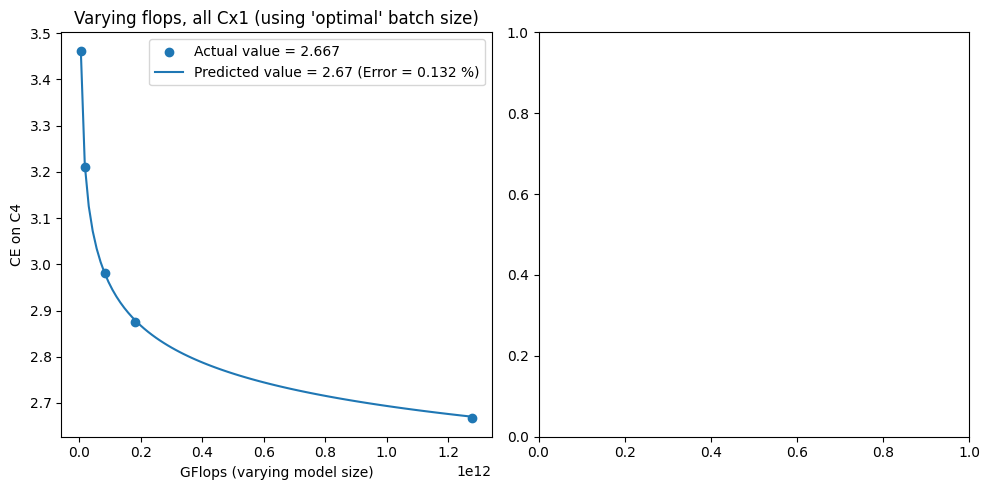

In [343]:
import numpy as np
import matplotlib.pyplot as plt

def power_law(x, a, b, c):
    return a * x ** b + c

power_law_bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf])

from scipy.optimize import curve_fit

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# model size
x = []
y = []

for run in validation_outputs:
    x.append(gflops[run])
    y.append(ce_loss[run])

print(x, y)

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, train_x, train_y, p0=(100, -0.2, 1.5), bounds=power_law_bounds, max_nfev=50000)

ax1.scatter(x, y)
ax1.set_title("Varying flops, all Cx1 (using 'optimal' batch size)")
ax1.set_xlabel("GFlops (varying model size)")
ax1.set_ylabel("CE on C4") # and Pile
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, *popt))

pred_plots = power_law(x, *popt)

actual = y[-1]
predicted = pred_plots[-1]
error = abs(actual - predicted) * 100 / actual

legends = []
legends.append(f"Actual value = {round(actual, 3)}")
legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

ax1.legend(legends, loc="upper right")

# model size
x = []
y = []

for run in validation_outputs:
    x.append(gflops[run])
    y.append(downstream[run])

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])

power_law_bounds = ([-np.inf, -np.inf, 0], [0, 0, np.inf])
popt, pcov = curve_fit(power_law, train_x, train_y, p0=(-10, -1, 1.5), bounds=power_law_bounds, max_nfev=50000)

# ax2.scatter(x, y)
# ax2.set_title("Varying flops, all Cx1")
# ax2.set_xlabel("GFlops")
# ax2.set_ylabel("Downstream (hellaswag)")
# x = np.linspace(min(x), max(x), 100)
# ax2.plot(x, power_law(x, *popt))

# pred_plots = power_law(x, *popt)

# actual = y[-1]
# predicted = pred_plots[-1]
# error = abs(actual - predicted) * 100 / actual

# legends = []
# legends.append(f"Actual value = {round(actual, 3)}")
# legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

# ax2.legend(legends, loc="upper right")

plt.tight_layout()
plt.show()

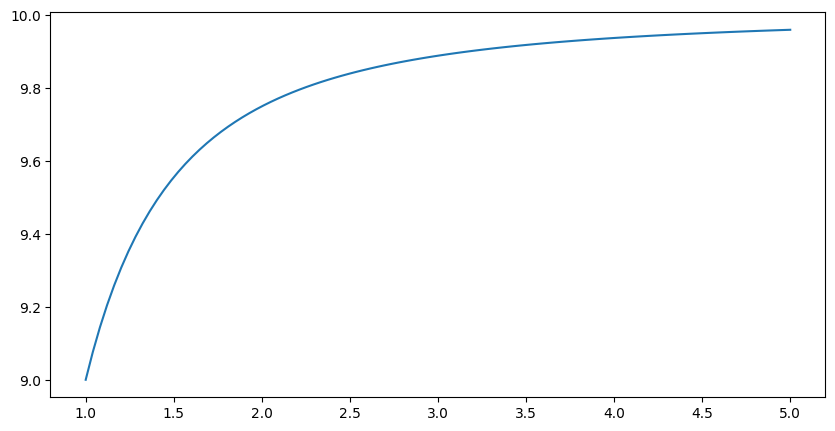

In [344]:
def power_law(x, a, b, c):
    return a * x ** b + c

fix, ax1 = plt.subplots(1, figsize=(10, 5))
x = [1, 2, 3, 4, 5]
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, a=-1, b=-2, c=10))
plt.show()

In [332]:
x

array([1.        , 1.04040404, 1.08080808, 1.12121212, 1.16161616,
       1.2020202 , 1.24242424, 1.28282828, 1.32323232, 1.36363636,
       1.4040404 , 1.44444444, 1.48484848, 1.52525253, 1.56565657,
       1.60606061, 1.64646465, 1.68686869, 1.72727273, 1.76767677,
       1.80808081, 1.84848485, 1.88888889, 1.92929293, 1.96969697,
       2.01010101, 2.05050505, 2.09090909, 2.13131313, 2.17171717,
       2.21212121, 2.25252525, 2.29292929, 2.33333333, 2.37373737,
       2.41414141, 2.45454545, 2.49494949, 2.53535354, 2.57575758,
       2.61616162, 2.65656566, 2.6969697 , 2.73737374, 2.77777778,
       2.81818182, 2.85858586, 2.8989899 , 2.93939394, 2.97979798,
       3.02020202, 3.06060606, 3.1010101 , 3.14141414, 3.18181818,
       3.22222222, 3.26262626, 3.3030303 , 3.34343434, 3.38383838,
       3.42424242, 3.46464646, 3.50505051, 3.54545455, 3.58585859,
       3.62626263, 3.66666667, 3.70707071, 3.74747475, 3.78787879,
       3.82828283, 3.86868687, 3.90909091, 3.94949495, 3.98989

In [333]:
ce_loss = {}
#gflops = {}

from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

for run_name, output_path in validation_outputs.items():
    df_val = pd.read_csv(output_path)
    #gflops[run_name] = df_val["throughput/total_training_Gflops"].values[-1]
    ce_loss[run_name] = np.mean([df_val[f"eval/{d}/CrossEntropyLoss"].values[-1] for d in validation_names])


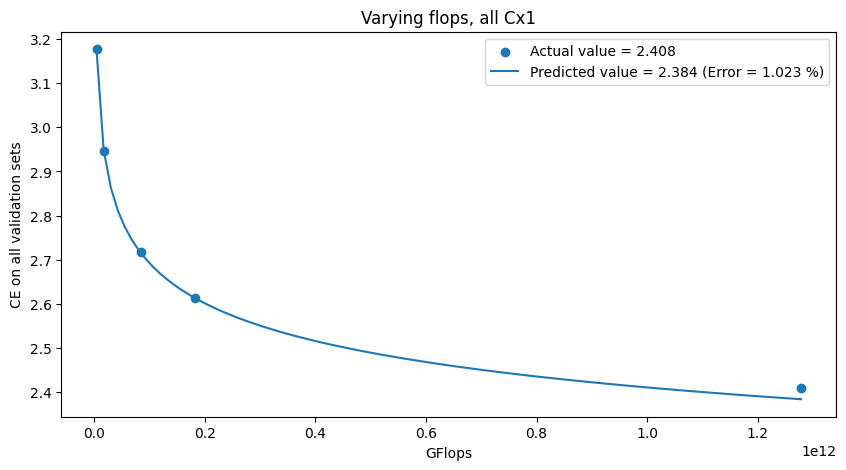

In [334]:
import numpy as np
import matplotlib.pyplot as plt

def power_law(x, a, b, c):
    return a * x ** b + c

power_law_bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf])

from scipy.optimize import curve_fit

fix, ax1 = plt.subplots(1, figsize=(10, 5))

# model size
x = []
y = []

for run in validation_outputs:
    x.append(gflops[run])
    y.append(ce_loss[run])

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, train_x, train_y, p0=(100, -0.2, 1.5), bounds=power_law_bounds, max_nfev=50000)

ax1.scatter(x, y)
ax1.set_title("Varying flops, all Cx1")
ax1.set_xlabel("GFlops")
ax1.set_ylabel("CE on all validation sets")
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, *popt))

pred_plots = power_law(x, *popt)

actual = y[-1]
predicted = pred_plots[-1]
error = abs(actual - predicted) * 100 / actual

legends = []
legends.append(f"Actual value = {round(actual, 3)}")
legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

ax1.legend(legends, loc="upper right")

In [302]:
ce_loss = {}
#gflops = {}

from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

for run_name, output_path in validation_outputs.items():
    df_val = pd.read_csv(output_path)
    #gflops[run_name] = df_val["throughput/total_training_Gflops"].values[-1]
    ce_loss[run_name] = np.mean([df_val[f"eval/{d}/CrossEntropyLoss"].values[-1] for d in validation_names])

### Mapping validation loss to downstream performance

In [303]:
ce_loss = {}
downstream = {}

from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

for run_name, output_path in validation_outputs.items():
    df_val = pd.read_csv(output_path)
    df_down = pd.read_csv(downstream_outputs[run_name])
    ce_loss[run_name] = np.mean([df_val[f"eval/{d}/CrossEntropyLoss"].values[-1] for d in validation_names])
    downstream[run_name] = df_down["eval/downstream/hellaswag_len_norm"].values[-1] #np.mean([df_down[f"eval/downstream/{d}"].values[-1] for d in downstream_names])

In [304]:
ce_loss

{'amberish-150M-1xC': 3.203245097940618,
 'amberish-bs-256-300M-1xC': 2.946972673589533,
 'amberish-750M-1xC': 2.7179347601803867,
 'amberish-1B-1xC': 2.6124743114818227,
 'amberish-3B-1xC': 2.4082609956914727}

In [305]:
downstream

{'amberish-150M-1xC': 0.2932682633399963,
 'amberish-bs-256-300M-1xC': 0.3422625064849853,
 'amberish-750M-1xC': 0.4260107576847076,
 'amberish-1B-1xC': 0.4780920147895813,
 'amberish-3B-1xC': 0.6014738082885742}

[3.2032451  2.94697267 2.71793476 2.61247431] [0.70673174 0.65773749 0.57398924 0.52190799]
[-67.70939125  -5.75306253   0.79097126]


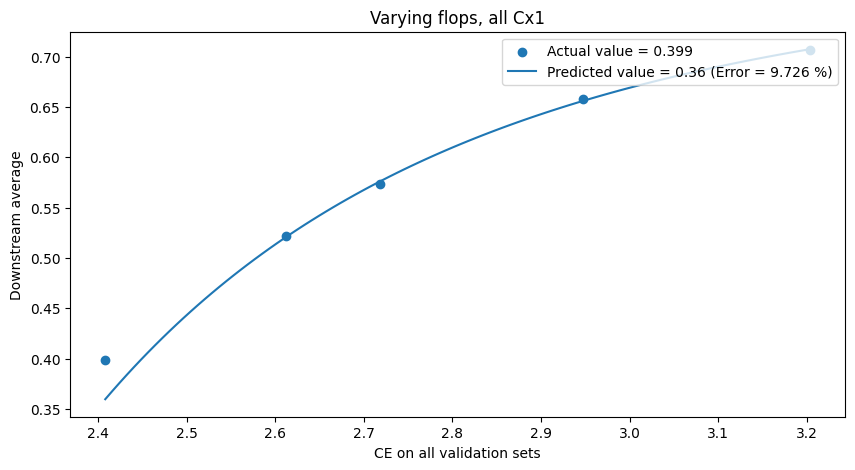

In [306]:
import numpy as np
import matplotlib.pyplot as plt

def power_law(x, a, b, c):
    return a * x ** b + c

#power_law_bounds = ([-np.inf, 0, 0], [0, np.inf, np.inf])
power_law_bounds = ([-np.inf, -np.inf, 0], [0, 0, np.inf])

from scipy.optimize import curve_fit

fix, ax1 = plt.subplots(1, figsize=(10, 5))

# model size
x = []
y = []

for run in validation_outputs:
    x.append(ce_loss[run])
    y.append(1-downstream[run])

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])

print(train_x, train_y)

popt, pcov = curve_fit(power_law, train_x, train_y, p0=(-100, -0.2, 1.5), bounds=power_law_bounds, max_nfev=500000)

print(popt)

ax1.scatter(x, y)
ax1.set_title("Varying flops, all Cx1")
ax1.set_xlabel("CE on all validation sets")
ax1.set_ylabel("Downstream average")
x = np.linspace(max(x), min(x), 100)
ax1.plot(x, power_law(x, *popt))

pred_plots = power_law(x, *popt)

actual = y[-1]
predicted = pred_plots[-1]
error = abs(actual - predicted) * 100 / actual

legends = []
legends.append(f"Actual value = {round(actual, 3)}")
legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

ax1.legend(legends, loc="upper right")

In [345]:
run_names = [
    "ai2-llm/olmo-ladder/amberish-150M-1xC",
    "ai2-llm/olmo-ladder/amberish-bs-256-300M-1xC",
    "ai2-llm/olmo-ladder/amberish-750M-1xC",
    "ai2-llm/olmo-ladder/amberish-1B-1xC",
    "ai2-llm/olmo-ladder/amberish-3B-1xC"
]

downstream_loss_outputs = {}

for run_name in run_names:

    output_name = run_name.split("/")[-1]
    output_path = f"wandb/{output_name}-all-downstream-loss.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_training_Gflops",
        y_axis=[f"eval/downstream_ce_loss/{d}" for d in ["trivia_qa_wiki_ppl_ce_loss", "arc_easy_ppl_ce_loss", "natural_qs_open_ppl_ce_loss"]],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    downstream_loss_outputs[output_name] = output_path

Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/apwh1wq9 (finished)>
<Run ai2-llm/olmo-ladder/jlq83qfw (failed)>


  0%|                                                                                                                             | 0/2 [00:00<?, ?it/s]

Processing amberish-150M-1xC


 50%|██████████████████████████████████████████████████████████▌                                                          | 1/2 [00:00<00:00,  1.77it/s]

Processing amberish-150M-1xC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/gkf1dhqr (finished)>


  0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Processing amberish-bs-256-300M-1xC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/cbij58b6 (finished)>


  0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Processing amberish-750M-1xC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/qah1jr09 (finished)>


  0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Processing amberish-1B-1xC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/dnvyaa4z (finished)>
<Run ai2-llm/olmo-ladder/m5of6hmk (failed)>


  0%|                                                                                                                             | 0/2 [00:00<?, ?it/s]

Processing amberish-3B-1xC


 50%|██████████████████████████████████████████████████████████▌                                                          | 1/2 [00:00<00:00,  1.78it/s]

Processing amberish-3B-1xC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]


In [375]:
down_ce_loss = {}
#gflops = {}

from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

for run_name, output_path in downstream_loss_outputs.items():
    df_down_loss = pd.read_csv(output_path)
    #gflops[run_name] = df_val["throughput/total_training_Gflops"].values[-1]
    #ce_loss[run_name] = np.mean([df_val[f"eval/{d}/CrossEntropyLoss"].values[-1] for d in validation_names])
    #down_ce_loss[run_name] = np.mean([df_down_loss[f"eval/downstream_ce_loss/{d}"].values[-1] for d in ["trivia_qa_wiki_ppl_ce_loss", "arc_easy_ppl_ce_loss", "natural_qs_open_ppl_ce_loss"]])
    down_ce_loss[run_name] = df_down_loss["eval/downstream_ce_loss/arc_easy_ppl_ce_loss"].values[-1]

In [376]:
down_ce_loss

{'amberish-150M-1xC': 1.216868877410889,
 'amberish-bs-256-300M-1xC': 1.0405633449554443,
 'amberish-750M-1xC': 0.9536046981811525,
 'amberish-1B-1xC': 0.9238315224647522,
 'amberish-3B-1xC': 0.9169030785560608}

In [377]:
gflops

{'amberish-150M-1xC': 4569042832.5888,
 'amberish-bs-256-300M-1xC': 17621077668.79342,
 'amberish-750M-1xC': 84206674904.64223,
 'amberish-1B-1xC': 181940730754.81943,
 'amberish-3B-1xC': 1278250000000.0}

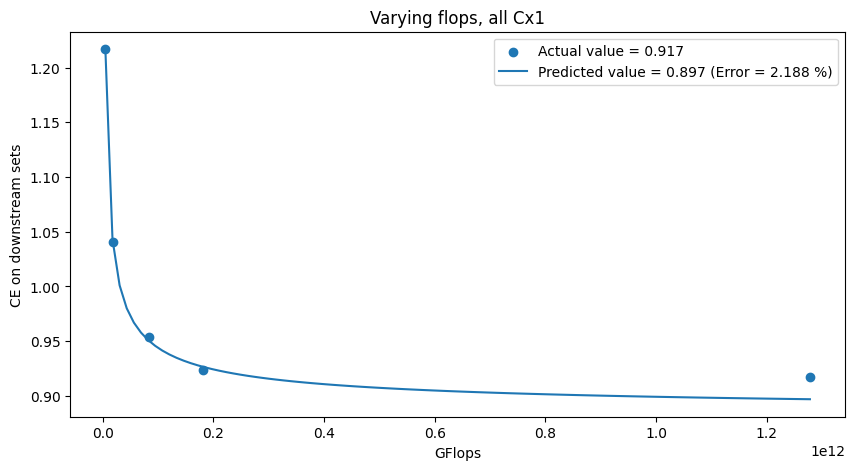

In [378]:
import numpy as np
import matplotlib.pyplot as plt

def linear_law(x, a, b):
    return a * x + b

power_law_bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf])

from scipy.optimize import curve_fit

fix, ax1 = plt.subplots(1, figsize=(10, 5))

# model size
x = []
y = []

for run in down_ce_loss:
    #if "3B" not in run:
    x.append(gflops[run])
    y.append(down_ce_loss[run])

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])

# train_x = np.array(x)
# train_y = np.array(y)

popt, pcov = curve_fit(power_law, train_x, train_y, p0=(100, -1, 1.5), bounds=power_law_bounds, max_nfev=500000)

ax1.scatter(x, y)
ax1.set_title("Varying flops, all Cx1")
ax1.set_xlabel("GFlops")
ax1.set_ylabel("CE on downstream sets")
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, *popt))

pred_plots = power_law(x, *popt)

actual = y[-1]
predicted = pred_plots[-1]
error = abs(actual - predicted) * 100 / actual

legends = []
legends.append(f"Actual value = {round(actual, 3)}")
legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

ax1.legend(legends, loc="upper right")

In [385]:
down_ce_loss = {}
down_acc = {}

from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

for run_name, output_path in downstream_loss_outputs.items():
    df_down = pd.read_csv(downstream_outputs[run_name])
    df_down_loss = pd.read_csv(output_path)
    #gflops[run_name] = df_val["throughput/total_training_Gflops"].values[-1]
    #ce_loss[run_name] = np.mean([df_val[f"eval/{d}/CrossEntropyLoss"].values[-1] for d in validation_names])
    #down_ce_loss[run_name] = np.mean([df_down_loss[f"eval/downstream_ce_loss/{d}"].values[-1] for d in ["trivia_qa_wiki_ppl_ce_loss", "arc_easy_ppl_ce_loss", "natural_qs_open_ppl_ce_loss"]])
    down_ce_loss[run_name] = df_down_loss["eval/downstream_ce_loss/arc_easy_ppl_ce_loss"].values[-1]
    down_acc[run_name] = df_down["eval/downstream/arc_easy_acc"].values[-1]

In [386]:
down_ce_loss

{'amberish-150M-1xC': 1.216868877410889,
 'amberish-bs-256-300M-1xC': 1.0405633449554443,
 'amberish-750M-1xC': 0.9536046981811525,
 'amberish-1B-1xC': 0.9238315224647522,
 'amberish-3B-1xC': 0.9169030785560608}

In [387]:
down_acc

{'amberish-150M-1xC': 0.4140350818634033,
 'amberish-bs-256-300M-1xC': 0.480701744556427,
 'amberish-750M-1xC': 0.5403508543968201,
 'amberish-1B-1xC': 0.5754386186599731,
 'amberish-3B-1xC': 0.5982456207275391}

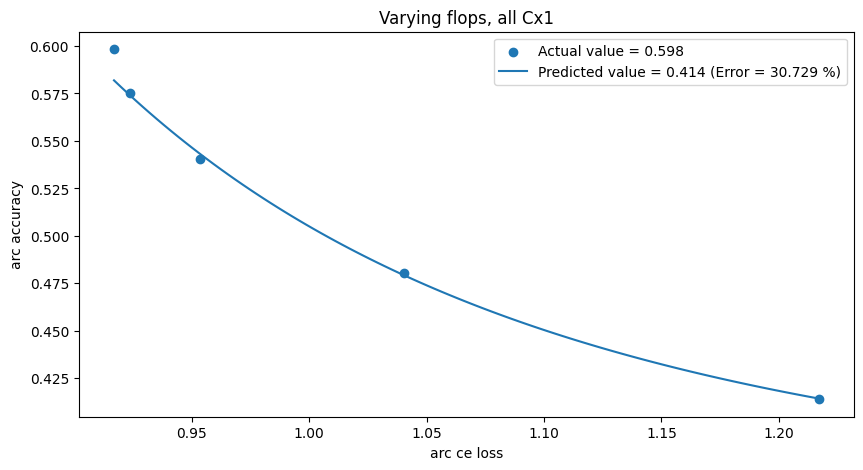

In [393]:
import numpy as np
import matplotlib.pyplot as plt

def linear_law(x, a, b):
    return a * x + b

power_law_bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf])

from scipy.optimize import curve_fit

fix, ax1 = plt.subplots(1, figsize=(10, 5))

# model size
x = []
y = []

for run in down_ce_loss:
    #if "3B" not in run:
    x.append(down_ce_loss[run])
    y.append(down_acc[run])

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])

# train_x = np.array(x)
# train_y = np.array(y)

popt, pcov = curve_fit(power_law, train_x, train_y, p0=(100, -1, 1.5), bounds=power_law_bounds, max_nfev=500000)

ax1.scatter(x, y)
ax1.set_title("Varying flops, all Cx1")
ax1.set_xlabel("arc ce loss")
ax1.set_ylabel("arc accuracy")
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, *popt))

pred_plots = power_law(x, *popt)

actual = y[-1]
predicted = pred_plots[-1]
error = abs(actual - predicted) * 100 / actual

legends = []
legends.append(f"Actual value = {round(actual, 3)}")
legends.append(f"Predicted value = {round(predicted, 3)} (Error = {round(error, 3)} %)")

ax1.legend(legends, loc="upper right")